In [3]:
import pandas_datareader.data as web
import datetime

In [4]:
# We specify the timeframe and download the prices with Yahoo Finance
start = datetime.datetime(2011, 1, 1)
end = datetime.datetime(2014, 1, 27)
coke_prices = web.DataReader("KO", 'yahoo', start, end)
pepsi_prices = web.DataReader("PEP", 'yahoo', start, end)

Let us take a look at what we downloaded.

In [5]:
coke_prices.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2011-01-03,65.879997,65.879997,65.110001,65.220001,18945600,27.033453
2011-01-04,65.019997,65.190002,63.810001,63.869999,27940400,26.473882
2011-01-05,63.790001,63.950001,62.860001,63.490002,34379000,26.316375
2011-01-06,63.619999,63.660000,62.830002,63.029999,21712400,26.125705
2011-01-07,62.779999,63.000000,62.560001,62.919998,16592800,26.080110


We are interested in the adjusted close. The close prices themselves do not work, because of stock splits.

In [6]:
coke_close=coke_prices['Adj Close']
pepsi_close=pepsi_prices['Adj Close']

Let us do a scatterplot. If they are cointegrated, then we expect to see the points clustered around a line

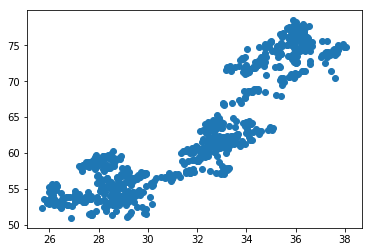

In [7]:
import matplotlib.pyplot as plt
plt.scatter(coke_close, pepsi_close)
plt.show()

We fit a line with linear regression
So pepsi = slope * coke + intercept + error

In [8]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(coke_close, pepsi_close)
print("slope: " + str(slope) +
      "\nintercept: " + str(intercept) +
      "\nr-value: " + str(r_value) +
      "\np-value: " + str(p_value) +
      "\nstd-err: " + str(std_err))

slope: 2.1868969195
intercept: -7.04139940461
r-value: 0.896540328487
p-value: 3.64783454604e-274
std-err: 0.0389638534876


The p-value is small, which is good.
Let us plot this thing with the fitted line

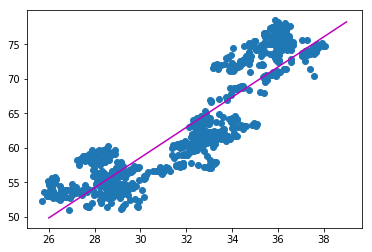

In [9]:
import matplotlib.pyplot as plt
plt.scatter(coke_close, pepsi_close)
x=[26,39]
plt.plot(x,[slope*x_i+intercept for x_i in x], color='m')
plt.show()

Now we compute the term e, which is the residue or the error term.
If the error is stationary, then Coke and Pepsi are cointegrated.

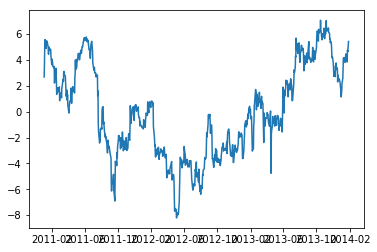

In [10]:
error = pepsi_close - slope * coke_close - intercept
plt.plot(error)
plt.show()

The plot looks okay, but it is not clear it if is really stationary.
E.g., there is an upward trending segment in the middle.
But we can test the error for stationarity.

In [11]:
import statsmodels.tsa.stattools as ts
ts.adfuller(error,1)

(-1.9345595231989032,
 0.31598188286172724,
 0,
 770,
 {'1%': -3.4388710830827125,
  '10%': -2.568772659807725,
  '5%': -2.8653008652386576},
 1257.1859133786406)

Remember the null hypothesis is, that there is a unit root.
Having a unit root, means that the process is not stationary.
The p-value is 0.31, so we cannot reject the null hypothesis.

Thus, Coke and Pepsi are not useful for pairs trading with the setup I described. There may be other setups, where it works. Maybe the timeframe is not useful. Maybe the error time series is not an AR(1)-process.

Let us take another example.
There is an iShares MSCI Australia and an iShares MSCI Canada. These are two ETFs which track the economy of Australia, respectively Canada. Their ticker symbols are EWA and EWC.
We will test their cointegration.

First, we define the timeframe and download the data from yahoo finance.

In [12]:
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2003, 1, 1)
end = datetime.datetime(2008, 1, 27)
ewa_prices = web.DataReader("EWA", 'yahoo', start, end)
ewc_prices = web.DataReader("EWC", 'yahoo', start, end)

Again, we need to trade on the adjusted closes. Let us plot the two charts.

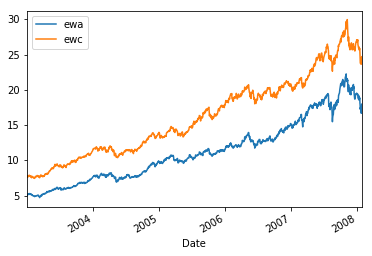

In [13]:
ewa_close=ewa_prices['Adj Close']
ewc_close=ewc_prices['Adj Close']

import matplotlib.pyplot as plt
ewa_close.plot(label='ewa', legend=True)
ewc_close.plot(label='ewc', legend=True)
plt.show()

We can see that they have common jumps, so we can go on to the next step: drawing a scatterplot.

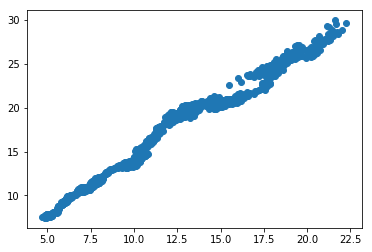

In [14]:
import matplotlib.pyplot as plt
plt.scatter(ewa_close, ewc_close)
plt.show()

This fairly looks like a line. Perfect. So we fit a line.

In [15]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(ewa_close, ewc_close)
print("slope: " + str(slope) +
      "\nintercept: " + str(intercept) +
      "\nr-value: " + str(r_value) +
      "\np-value: " + str(p_value) +
      "\nstd-err: " + str(std_err))

slope: 1.27629111076
intercept: 1.79841662559
r-value: 0.989386266306
p-value: 0.0
std-err: 0.00525367636547


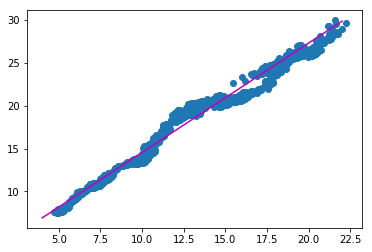

In [16]:
plt.scatter(ewa_close, ewc_close)
x=[4,22]
plt.plot(x,[slope*x_i+intercept for x_i in x], color='m')
plt.show()

Looks great. Now we compute the error and test if it is mean-reverting.

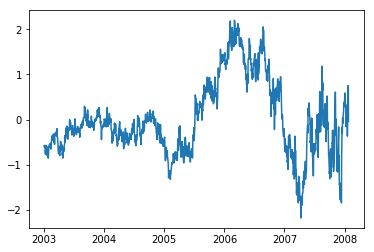

In [17]:
error = ewc_close - slope * ewa_close - intercept
plt.plot(error)
plt.show()

In [18]:
import statsmodels.tsa.stattools as ts
ts.adfuller(error,1)

(-3.3459094549609389,
 0.012946959495104054,
 1,
 1273,
 {'1%': -3.4354973175106842,
  '10%': -2.5679802172809003,
  '5%': -2.8638130956084464},
 -845.44796472685812)

We got a p-value of 0.0129. That means we are statistically significant. So we could go on to build a trading strat by trading on the error. The interesting part is that it is only significant, since I chose the timeframe appropriately. For other timeframes the cointegration relationship interestingly does not hold.